# 1. Imports

In [1]:
import pandas as pd
import numpy as np
import nltk
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# 2. Data preparation & understanding

### Define the stopwords for english language
We define the Set of stopwords for english, because is the language that texts on the dataframe are using.

In [2]:
nltk.download('punkt')

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/isabela/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/isabela/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Define the tokenizer function using word_tokenize

In [3]:
def tokenizer(text: str):
    return word_tokenize(text)

### Read data using Pandas

In [4]:
data = pd.read_csv('./DatosSuicidio/SuicidiosProyecto.csv', sep = ',', encoding = 'utf-8')

### Understanding how many rows and columns do we have and how are they labeled

In [5]:
data.shape

(195700, 3)

In [6]:
data.columns

Index(['Unnamed: 0', 'text', 'class'], dtype='object')

### Dropping first column
We decided to drop first column because it does not add any value to the model we want to make

In [7]:
data.drop(labels = ['Unnamed: 0'], axis = 'columns', inplace= True)

### Removing emojis from text of the dataset
Although emojis are important because sometimes they express how people feel, they are getting a huge important on the TfidfVectorizer, and not always they mean what they suppouse to mean

In [8]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

### Identifying the classification of the data

In [9]:
data['class'].value_counts(dropna = False, normalize = True)

non-suicide    0.562928
suicide        0.437072
Name: class, dtype: float64

### Selection TfidfVectorizer model
We selected TF-DIF model because of the size of the datase. Rather than using Bag of Words, we prefer TF-DIF by trying to find a fast and low cost solution.

In [10]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True, strip_accents= 'ascii', max_df = 0.001)

### Separate the data into Train and Test datasets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['class'], test_size = 0.2, stratify = data['class'], random_state = 1)

### Apply Train dataset to TfdifVectorizer model

In [12]:
X_tfidf = tfidf.fit_transform(X_train)

/Users/isabela/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


### Verifying the length of the vocabulary of the dataset
We got this legth of the vocabulary by using the paramter "max_df" in the TfidfVectorizer class, because it reduces the amount of times a word appears in the dataset by not using it as a token

In [13]:
len(tfidf.vocabulary_)

165787

# Entrenamiento con Support Vector Machines

In [15]:
# Se crea el objeto del clasificador support vector.
# Usamos un kernel lineal ya que estamos lidiando con text classification
tfidf_model = svm.SVC(kernel = 'linear')

In [16]:
# Entrenamos el modelo usando los training sets. 
tfidf_model.fit(X_tfidf, y_train)

SVC(kernel='linear')

## Predictions

In [17]:
# Predecimos la respuesta para el test dataset
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test))

## Confusion Matrix

### Train

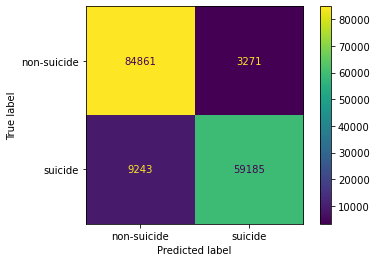

In [18]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

### Test

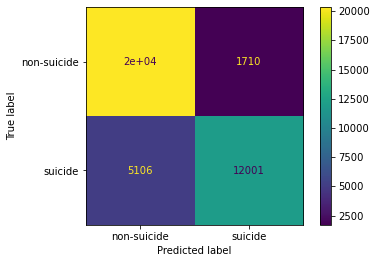

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

## Scores Precision, Recall and F1

### Train

In [20]:
if len(tfidf_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_tfidf_predict, pos_label = 'suicide'))
    print('Recall:', recall_score(y_train, y_train_tfidf_predict, pos_label = 'suicide'))
    print('F1:', f1_score(y_train, y_train_tfidf_predict, pos_label = 'suicide'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_tfidf_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_tfidf_predict, average = None))
    print('F1:', f1_score(y_train, y_train_tfidf_predict, average = None))

Precision: 0.9476271294991674
Recall: 0.8649237154381247
F1: 0.9043886189297394


## Scores Precision, Recall and F1

### Test

In [21]:
if len(tfidf_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_tfidf_predict, pos_label = 'suicide'))
    print('Recall:', recall_score(y_test, y_test_tfidf_predict, pos_label = 'suicide'))
    print('F1:', f1_score(y_test, y_test_tfidf_predict, pos_label = 'suicide'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
    print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: 0.8752826197943258
Recall: 0.7015256912375051
F1: 0.7788305535725875
